## GAN model Train 

### Import Library

In [ ]:
import numpy as np
import torch
from torch import Tensor, randn, ones, zeros, optim, save
from torch.nn import Module, Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, BCELoss
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

###  Random sample distribution Z.

In [ ]:

        
def generateNoise(N):
    """
    Random sample distribution Z.
    """
    noise = Variable(randn(N, 100))
    return noise



### Generative Network

In [ ]:
class Generator(Module):
    def __init__(self):
        super(Generator, self).__init__()
        d_input = 100
        d_output = 28*28
        
        self.input = Sequential(
            Linear(d_input, 256),
            ReLU()
        )
        self.hidden1 = Sequential(            
            Linear(256, 512),
            ReLU()
        )
        self.hidden2 = Sequential(
            Linear(512, 1024),
            ReLU()
        )
        self.output = Sequential(
            Linear(1024, d_output),
            Tanh()
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.output(x)
        return x

In [ ]:
Generator()

Generator(
  (input): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

###  Descriminative Network

In [ ]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        d_input = 28*28
        d_output = 1
        
        self.input = Sequential( 
            Linear(d_input, 1024),
            ReLU(),
            Dropout(0.2)
        )
        self.hidden1 = Sequential(
            Linear(1024, 512),
            ReLU(),
            Dropout(0.2)
        )
        self.hidden2 = Sequential(
            Linear(512, 256),
            ReLU(),
            Dropout(0.2)
        )
        self.output = Sequential(
            Linear(256, d_output),
            Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.output(x)
        return x

In [ ]:
Discriminator()

Discriminator(
  (input): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
""" 
Train Generator 

"""
def train_d(optim, trueData, falseData):
    trueN = trueData.size(0)
    falseN = falseData.size(0)
        
    # Train on true data
    optim.zero_grad()
    
    truePred = discriminator(trueData)
    
    trueError = loss(truePred, Variable(ones(trueN, 1)))
    trueError.backward()

    # Train on generated data
    falsePred = discriminator(falseData)
    falseError = loss(falsePred, Variable(zeros(falseN, 1)))
    falseError.backward()
    
    optim.step()

    return trueError + falseError

""" 
Train Generator based on Discriminators response 

"""
def train_g(optim, falseData):
    falseN = falseData.size(0)
    optim.zero_grad()

    pred = discriminator(falseData) # Response from Discriminator
    error = loss(pred, Variable(ones(falseN, 1))) # Pretending that the false data is true data
    error.backward()
    optim.step()
    
    return error

### MNIST daaset dowload and data loader

In [ ]:

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)                

In [ ]:
epochs = 2
generator = Generator()
discriminator = Discriminator()

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)
loss = BCELoss()

In [ ]:
errors_G = []
errors_D = []

print('-------- Training models --------')
for epoch in range(1, epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        # images, labels = images.to(device), labels.to(device)

        trueData = Variable(images)
        
        falseData = generator(generateNoise(images.size(0))).detach() # detach to not calculate gradients
        
        error_d = train_d(d_optim, trueData, falseData)

        # Train Generator
        falseData = generator(generateNoise(batch.size(0)))
        error_g = train_g(g_optim, falseData)
    
    print('Epoch', epoch)
    print('Generator Error:', error_g.data)
    print('Discriminator Error:', error_d.data)
    print()
    
    errors_G.append(error_g.data)
    errors_D.append(error_d.data)
print('-------- Finished training --------')   

-------- Training models --------
Epoch 1
Generator Error: tensor(3.0525)
Discriminator Error: tensor(0.3700)

-------- Finished training --------


### Save and loading model

In [ ]:
# save(generator.state_dict(), 'generator.pt')
# save(discriminator.state_dict(), 'discriminator.pt')
# generator = Generator()
# model.load_state_dict(torch.load('generator.pt'))

### Testing Generator

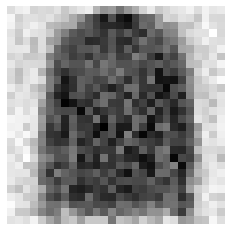

In [ ]:
testData = generator(generateNoise(100))

for image in testData:
    image = image.view(28,28).data
    plt.imshow(image, cmap='Greys')
    plt.axis('off')
    plt.show()
    break

### As we have seen GAN randomly generate Data. So we need to control our data generation by conditional GAN.

##Conditional GAN
 Conditional GAN, which is a GAN that allows you to choose the label of the generated image. 

### Import Library

In [ ]:
import numpy as np
import torch
from torch import Tensor, randn, ones, zeros, optim, save
from torch.nn import Module, Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, BCELoss
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### Dataloader

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)                

### Descriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [ ]:
Discriminator()

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [ ]:
Generator()

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [ ]:
generator = Generator()
discriminator = Discriminator()

### Loss and optimizer

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

In [ ]:
num_epochs = 2
n_critic = 5

In [ ]:
print('-------- Training Start --------')  
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(train_loader):
        real_images = Variable(images)
        labels = Variable(labels)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
print('-------- Finished training --------')  

-------- Training Start --------
Starting epoch 0...
Starting epoch 1...
-------- Finished training --------


### Testing by generating sample images by condition

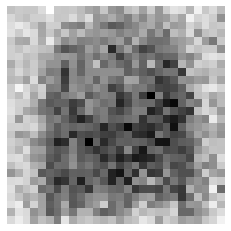

In [ ]:
## ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
z = Variable(torch.randn(1, 100))
label = Variable(torch.LongTensor([2]))

image = generator(z, label).unsqueeze(1).data

image = image.view(28,28).data
plt.imshow(image, cmap='Greys')
plt.axis('off')
plt.show()
    